In [1]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,Conv1D,Conv2D,Flatten,BatchNormalization,MaxPooling1D,Dropout,Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D,MaxPooling2D,ZeroPadding2D,AveragePooling2D
from tensorflow.keras.layers import Activation,Add,Reshape,Permute,LeakyReLU,UpSampling2D,Conv2DTranspose,Concatenate
from tensorflow.keras.layers import Lambda,InputSpec,Layer,Input,Add,ZeroPadding2D,UpSampling2D,MaxPooling2D,Conv2D,Bidirectional,LSTM
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.utils import resample
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam,SGD
import datetime
from tensorflow.keras.utils import plot_model
import os
import flask
import json


# def load_dataset():

ddata = pd.read_csv('./final_1/data1M.csv')
ddata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3701213 entries, 0 to 3701212
Data columns (total 79 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   dst_port                    int64  
 1   protocol                    int64  
 2   flow_duration               int64  
 3   total_fwd_packet            int64  
 4   total_bwd_packets           int64  
 5   total_length_of_fwd_packet  float64
 6   total_length_of_bwd_packet  float64
 7   fwd_packet_length_max       float64
 8   fwd_packet_length_min       float64
 9   fwd_packet_length_mean      float64
 10  fwd_packet_length_std       float64
 11  bwd_packet_length_max       float64
 12  bwd_packet_length_min       float64
 13  bwd_packet_length_mean      float64
 14  bwd_packet_length_std       float64
 15  flow_bytes_s                float64
 16  flow_packets_s              float64
 17  flow_iat_mean               float64
 18  flow_iat_std                float64
 19  flow_iat_max         

# DATA

In [230]:
df = ddata
# df = ddata[ddata['Label'] != 'DDOS']


In [231]:
# drop columns
df.drop(['Timestamp','Fwd Header Len'], axis=1, inplace=True)
df.drop(['Protocol'], axis=1, inplace=True)
# df.drop(['Dst Port'], axis=1, inplace=True)

In [232]:
df.describe(include=[int, float])
df.describe(include=[object]).transpose()

,count,unique,top,freq
Label,2166273,4,Benign,666273


# Dealing with duplicates

In [233]:
df.duplicated().any()

True

In [234]:
print('Data size BEFORE deleteting instances with duplicate values: ', df.shape[0], end='\n\n')

# Remove duplicate rows
df.drop_duplicates(inplace=True, keep=False, ignore_index=True)

print('Data size AFTER deleteting instances containing duplicate values: ', df.shape[0])

Data size BEFORE deleteting instances with duplicate values:  2166273

Data size AFTER deleteting instances containing duplicate values:  2054774


Dealing with missing values

In [235]:
df.isnull().sum().sum()
df.isnull().sum() / df.shape[0]

Dst Port           0.0
Flow Duration      0.0
Tot Fwd Pkts       0.0
Tot Bwd Pkts       0.0
TotLen Fwd Pkts    0.0
                  ... 
Idle Mean          0.0
Idle Std           0.0
Idle Max           0.0
Idle Min           0.0
Label              0.0
Length: 77, dtype: float64

In [236]:
df.columns[df.isnull().any()]

Index(['Flow Byts/s'], dtype='object')

In [237]:
print('Data size BEFORE deleteting instances with missing values: ', df.shape[0], end='\n\n')

# Remove missing values
df.dropna(axis=0, inplace=True, how="any")

print('Data size AFTER deleteting instances containing missing values: ', df.shape[0])

Data size BEFORE deleteting instances with missing values:  2054774

Data size AFTER deleteting instances containing missing values:  2047410


# Dealing with infinite values

In [238]:
# Checking if all values are finite.
np.all(np.isfinite(df.drop(['Label'], axis=1)))

False

In [239]:
# Replace infinite values to NaN
df.replace([-np.inf, np.inf], np.nan, inplace=True)

# Check which labels are related to infinte values
df[(df['Flow Byts/s'].isnull()) & (df['Flow Pkts/s'].isnull())].Label.unique()


array(['DDOS', 'Password_attack', 'Benign'], dtype=object)

In [240]:
print('Data size BEFORE deleteting instances with infinite values: ', df.shape[0], end='\n\n')

# Remove infinte values
df.dropna(axis=0, how='any', inplace=True)

print('Data size AFTER deleteting instances containing infinite values: ', df.shape[0])

Data size BEFORE deleteting instances with infinite values:  2047410

Data size AFTER deleteting instances containing infinite values:  2045728


# Dealing with features with quasi null std deviation

In [241]:
dataset_std = df.std(numeric_only=True)
dataset_std

Dst Port           2.095694e+04
Flow Duration      9.022996e+08
Tot Fwd Pkts       3.174286e+01
Tot Bwd Pkts       7.510462e+01
TotLen Fwd Pkts    1.126421e+04
                       ...     
Active Min         7.224542e+05
Idle Mean          7.440004e+14
Idle Std           8.602723e+13
Idle Max           7.441497e+14
Idle Min           7.487829e+14
Length: 76, dtype: float64

In [242]:
# Find Features that meet the threshold
constant_features = [column for column, std in dataset_std.iteritems() if std < 0.01]

# Drop the constant features
df.drop(labels=constant_features, axis=1, inplace=True)
print(constant_features)

['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'CWE Flag Count', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg']


C:\Users\fancyma\AppData\Local\Temp\ipykernel_16524\1058764042.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  constant_features = [column for column, std in dataset_std.iteritems() if std < 0.01]


# Observing the outliers

In [243]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers with interquartile range
filt = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
print(filt.sum())

C:\Users\fancyma\AppData\Local\Temp\ipykernel_16524\4034545612.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.25)
C:\Users\fancyma\AppData\Local\Temp\ipykernel_16524\4034545612.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.75)
C:\Users\fancyma\AppData\Local\Temp\ipykernel_16524\4034545612.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  filt = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))


ACK Flag Cnt       883134
Active Max          85682
Active Mean         85682
Active Min          85682
Active Std          56431
                    ...  
Tot Bwd Pkts       136485
Tot Fwd Pkts       177656
TotLen Bwd Pkts    450718
TotLen Fwd Pkts    385732
URG Flag Cnt        33015
Length: 70, dtype: int64


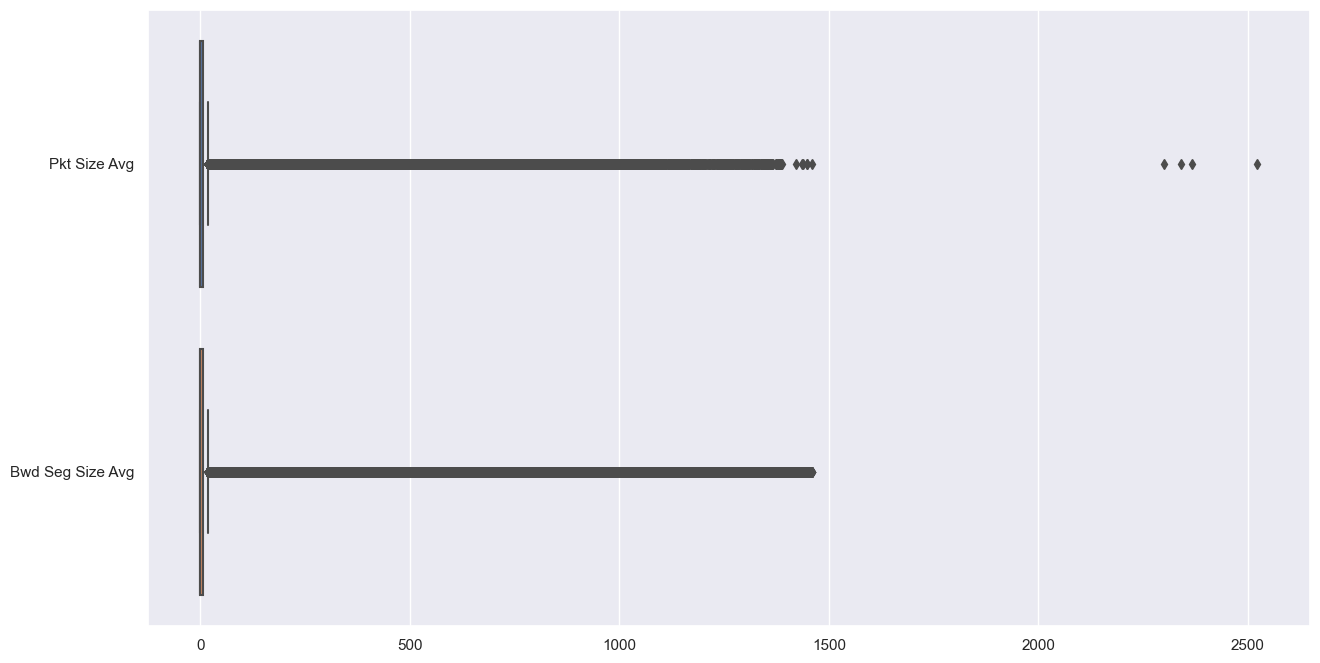

In [244]:
fig = plt.figure(figsize=(15, 8))
sns.boxplot(data=df[['Pkt Size Avg', 'Bwd Seg Size Avg']], orient="h")

#plt.title('Summary of some variables containing outliers', fontsize=18)
plt.show()
fig.savefig(os.path.join('./images', 'outliers.pdf'))

Convert the dtype of some features

In [245]:
df[['Flow Byts/s', 'Flow Pkts/s']] = df[['Flow Byts/s', 'Flow Pkts/s']].apply(pd.to_numeric)

Create a new feature `Port Category`

In [246]:
conds = [
    (df['Dst Port'] >= 1) & (df['Dst Port'] < 1024),
    (df['Dst Port'] >= 1024) & (df['Dst Port'] < 49152),
    (df['Dst Port'] >= 49152) & (df['Dst Port'] <= 65535)
]

choices = [
    "1 - 1023", 
    "1024 - 49151",
    "49152 - 65535"
]

df.insert(1, 'destination_port_category', np.select(conds, choices, default="0"))

# Data Exploration

### Correlation Matrix

In [247]:
dataset_corr = df.corr()
dataset_corr.head(5)

C:\Users\fancyma\AppData\Local\Temp\ipykernel_16524\306764757.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset_corr = df.corr()


,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Dst Port,1.000000,-0.002725,-0.049271,-0.033017,-0.010996,-0.015320,-0.245062,-0.147390,-0.266136,-0.251601,...,-0.235090,0.226022,-0.046083,-0.048276,-0.059258,-0.040236,0.208798,-0.021129,0.206954,0.209160
Flow Duration,-0.002725,1.000000,-0.003859,0.002415,0.000461,0.001779,0.007451,-0.000590,0.005466,0.007035,...,0.011683,-0.002358,0.003177,0.006654,0.005438,0.002340,-0.005537,0.001517,-0.005407,-0.005623
Tot Fwd Pkts,-0.049271,-0.003859,1.000000,0.886141,0.058036,0.880038,0.136634,-0.016311,0.091538,0.111430,...,0.252622,-0.059646,0.071373,0.093313,0.100774,0.059235,-0.071443,0.022608,-0.069513,-0.072804
Tot Bwd Pkts,-0.033017,0.002415,0.886141,1.000000,0.061129,0.996957,0.091061,-0.009999,0.051777,0.065362,...,0.202935,-0.032649,0.066563,0.078012,0.090461,0.056362,-0.042428,0.013140,-0.041305,-0.043213
TotLen Fwd Pkts,-0.010996,0.000461,0.058036,0.061129,1.000000,0.012768,0.296734,-0.001630,0.329764,0.222134,...,0.432054,-0.013799,0.011552,0.013284,0.015400,0.009921,-0.018214,0.006857,-0.017629,-0.018649


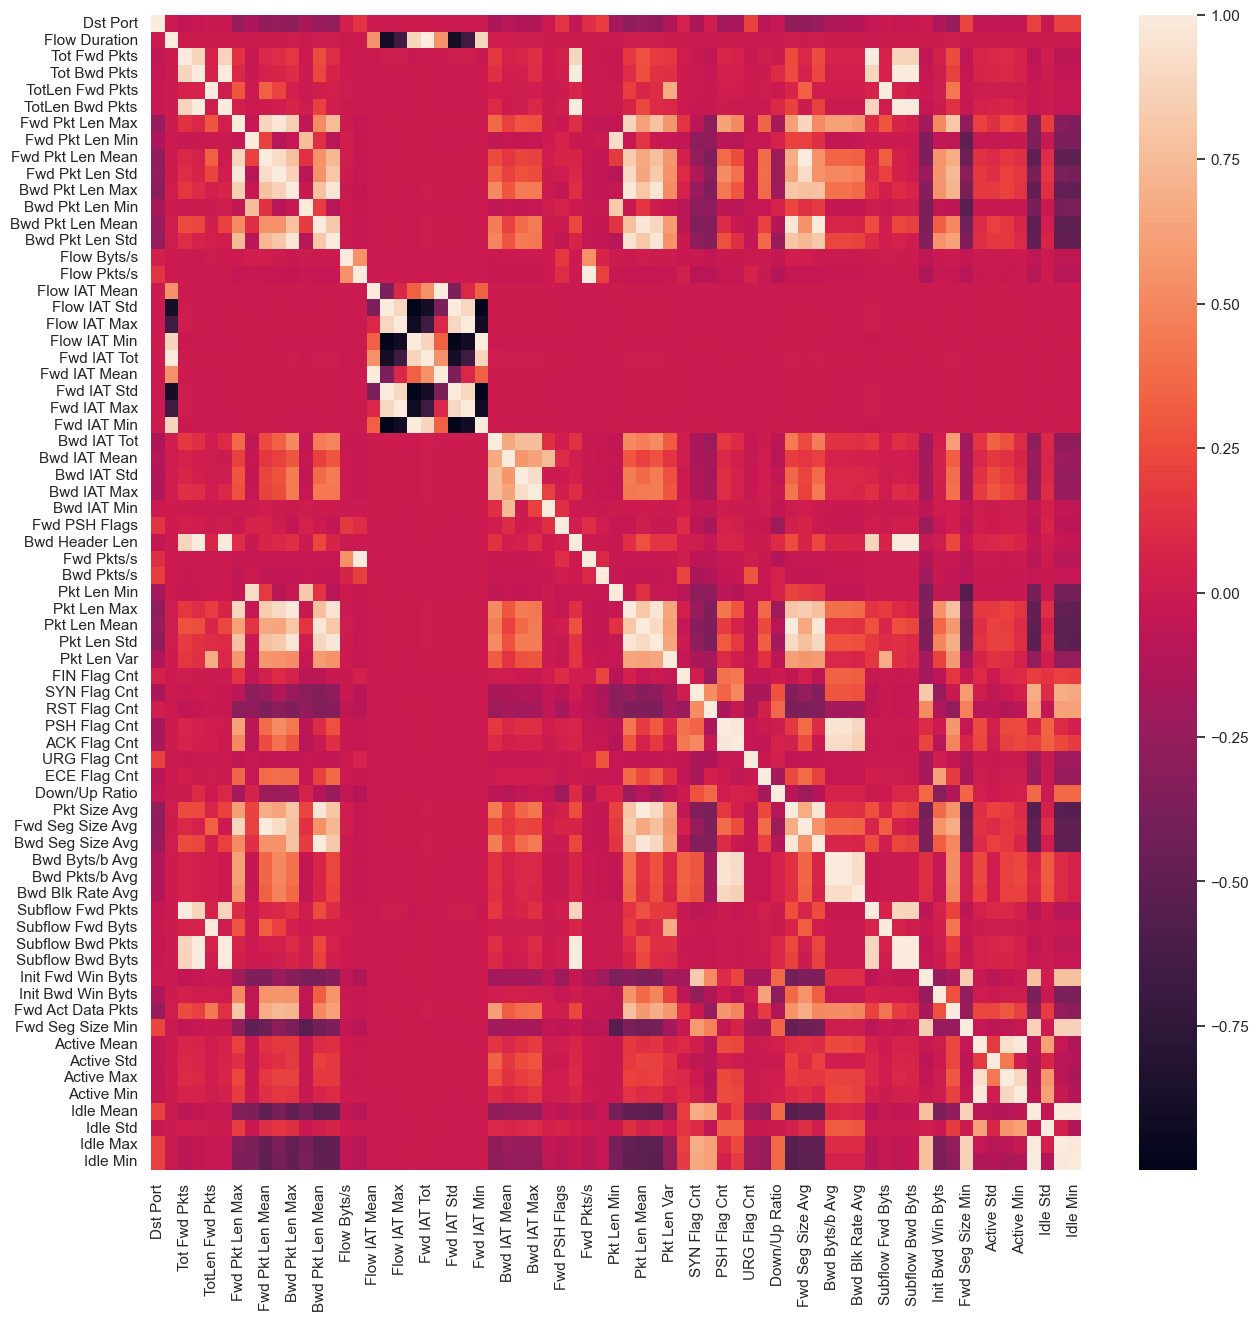

In [248]:
fig = plt.figure(figsize=(15, 15))
sns.set(font_scale=1.0)
ax = sns.heatmap(dataset_corr, annot=False)
fig.savefig(os.path.join('./images', 'correlation matrix.pdf'))

In [249]:
# Create & Apply mask
mask = np.triu(np.ones_like(dataset_corr, dtype=bool))
tri_df = dataset_corr.mask(mask)

# Find Features that meet the threshold
correlated_features = [c for c in tri_df.columns if any(tri_df[c] > 0.98)]
print(correlated_features)
# Drop the highly correlated features
df.drop(labels=correlated_features, axis=1, inplace=True)

['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Bwd Header Len', 'Pkt Len Mean', 'Bwd Byts/b Avg', 'Subflow Bwd Pkts', 'Active Mean', 'Idle Mean', 'Idle Max']


# Information about the data

In [250]:
# drop columns
print(df.info())
train_dataset = df
print(train_dataset['Label'].value_counts())
# df.to_csv('./final_1/final_had_p.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2045728 entries, 0 to 2054773
Data columns (total 51 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Dst Port                   int64  
 1   destination_port_category  object 
 2   Fwd Pkt Len Max            float64
 3   Fwd Pkt Len Min            float64
 4   Fwd Pkt Len Std            float64
 5   Bwd Pkt Len Min            float64
 6   Bwd Pkt Len Std            float64
 7   Flow Byts/s                float64
 8   Fwd IAT Tot                float64
 9   Fwd IAT Mean               float64
 10  Fwd IAT Std                float64
 11  Fwd IAT Max                float64
 12  Fwd IAT Min                float64
 13  Bwd IAT Tot                float64
 14  Bwd IAT Mean               float64
 15  Bwd IAT Std                float64
 16  Bwd IAT Max                float64
 17  Bwd IAT Min                float64
 18  Fwd PSH Flags              int64  
 19  Fwd Pkts/s                 float64
 20  Bw

# Port Usage Comparaison

In [251]:
# fig, ax = plt.subplots(figsize=(10,10))

# benign_ports = df.loc[df['Label'] == 'Benign', 'destination_port_category']
# malicious_ports = df.loc[df['Label'] != 'Benign', 'destination_port_category']

# # get rid of rows with specific value
# benign_ports = benign_ports[benign_ports != "0"]
# malicious_ports = malicious_ports[malicious_ports != "0"]

# # sum each port category column
# benign_ports = benign_ports.value_counts()
# malicious_ports = malicious_ports.value_counts()

# indexes = np.arange(3)
# width = 0.4
# rect1 = plt.bar(indexes, benign_ports.values, width, color="steelblue", label="benign")
# rect2 = plt.bar(indexes + width, malicious_ports.values, width, color="indianred", label="malicious")

# def add_text(rect):
#     # add text to top of each bar
#     for r in rect:
#         h = r.get_height()
#         plt.text(r.get_x() + r.get_width()/2, h*1.01, s=format(h, ",") ,fontsize=12, ha='center', va='bottom')

# add_text(rect1)
# add_text(rect2)

# ax.set_xticks(indexes + width / 2)
# ax.set_xticklabels(["1 - 1,023", "1,024 - 49,151", "49,152 - 65,535"])
# plt.title('Distribution of Port Usage\nAccording to Network Activity Type')
# plt.xlabel('Port Range')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(True)
# plt.show()
# fig.savefig(os.path.join('./images/', 'port_usage_comparison.pdf'))

# Label encoding

In [252]:
# encode label
labelE = LabelEncoder()
train_dataset['Label'] = labelE.fit_transform(train_dataset['Label'])
train_dataset['Label'].value_counts()
y = train_dataset['Label']
train_dataset = train_dataset.drop(['Label'],axis=1)
train_dataset = train_dataset.drop(['destination_port_category'],axis=1)


In [253]:
df.drop(['destination_port_category'], axis=1, inplace=True)

# Normalization

In [254]:
# normalize data
sc = StandardScaler()
train_dataset = sc.fit_transform(train_dataset)
train_dataset = pd.DataFrame(train_dataset,columns=df.columns[:-1])

In [255]:
# split data
X_train, X_test, y_train, y_test = train_test_split(train_dataset, y, test_size=0.1, random_state=42)

In [263]:
def re_shape(X_train,X_test,y_train,y_test):
    X_train = X_train.to_numpy().reshape(len(X_train),X_train.shape[1],1)
    X_test = X_test.to_numpy().reshape(len(X_test),X_test.shape[1],1)
    return X_train,X_test,y_train,y_test


def mutil_head_double_layers_evaluate_model2(time,Xtrain,ytrain,Xtest,ytest,logdir,epochs=10,batch_size=128,lr =0.001):
    input1s = Input(shape=(Xtrain.shape[1],1))
    conv1d_1s1 = Conv1D(filters=32,kernel_size=3,activation='relu',padding='same')(input1s)
    batch_1s1 = BatchNormalization()(conv1d_1s1)
    maxpool_1s1 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_1s1)
    flat1 = Flatten()(maxpool_1s1)

    input2s = Input(shape=(Xtrain.shape[1],1))
    conv1d_2s1 = Conv1D(filters=32,kernel_size=5,activation='relu',padding='same')(input2s)
    batch_2s1 = BatchNormalization()(conv1d_2s1)
    maxpool_2s1 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_2s1)
    flat2 = Flatten()(maxpool_2s1)
    
    input3s = Input(shape=(Xtrain.shape[1],1))
    conv1d_3s1 = Conv1D(filters=32,kernel_size=7,activation='relu',padding='same')(input3s)
    batch_3s1 = BatchNormalization()(conv1d_3s1)
    maxpool3 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_3s1)
    flat3 = Flatten()(maxpool3)

    concat = concatenate([flat1,flat2,flat3])
    dense1 = Dense(256,activation='relu')(concat)
    drop = Dropout(0.2)(dense1)
    dense2 = Dense(4,activation='softmax')(drop)
    model = Model(inputs=[input1s,input2s,input3s],outputs=dense2)
    #plot model
    plot_model(model, to_file=f'models/{time}/model_{time}.png', show_shapes=True, show_layer_names=True)

    opt = SGD(lr=lr, momentum=0.9)  
    model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    logdir = logdir + time
    tensorboard_callback = TensorBoard(log_dir=logdir)
    calls = [tensorboard_callback,
            #  EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto'),
            #  ModelCheckpoint(filepath=f'models/{time}/model_{time}.h5',monitor='val_loss',save_best_only=True,mode='auto'),
            #  ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,verbose=1,mode='auto',min_delta=0.0001,cooldown=0,min_lr=0)
            ]
    model.fit([Xtrain,Xtrain,Xtrain],ytrain,epochs=epochs,batch_size=batch_size,validation_data=([Xtest,Xtest,Xtest],ytest),callbacks=calls,verbose=1)
    # _,acc = model.evaluate([Xtest,Xtest,Xtest],ytest,verbose=0)
    # print("Accuracy: %.2f%%" % (acc*100))
    return model

def mutil_head_double_layers_evaluate_model(time,Xtrain,ytrain,Xtest,ytest,logdir,epochs=10,batch_size=128,lr =0.001):
    input1s = Input(shape=(Xtrain.shape[1],1))
    conv1d_1s1 = Conv1D(filters=32,kernel_size=3,activation='relu',padding='same')(input1s)
    batch_1s1 = BatchNormalization()(conv1d_1s1)
    maxpool_1s1 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_1s1)
    conv1d_1s2 = Conv1D(filters=32,kernel_size=3,activation='relu',padding='same')(maxpool_1s1)
    batch_1s2 = BatchNormalization()(conv1d_1s2)
    maxpool_1s2 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_1s2)
    flat1 = Flatten()(maxpool_1s2)

    input2s = Input(shape=(Xtrain.shape[1],1))
    conv1d_2s1 = Conv1D(filters=64,kernel_size=5,activation='relu',padding='same')(input2s)
    batch_2s1 = BatchNormalization()(conv1d_2s1)
    maxpool_2s1 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_2s1)
    conv1d_2s2 = Conv1D(filters=64,kernel_size=5,activation='relu',padding='same')(maxpool_2s1)
    batch_2s2 = BatchNormalization()(conv1d_2s2)
    maxpool_2s2 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_2s2)
    flat2 = Flatten()(maxpool_2s2)
    
    input3s = Input(shape=(Xtrain.shape[1],1))
    conv1d_3s1 = Conv1D(filters=128,kernel_size=7,activation='relu',padding='same')(input3s)
    batch_3s1 = BatchNormalization()(conv1d_3s1)
    maxpool3 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_3s1)
    conv1d_3s2 = Conv1D(filters=128,kernel_size=7,activation='relu',padding='same')(maxpool3)
    batch_3s2 = BatchNormalization()(conv1d_3s2)
    maxpool_3s2 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_3s2)
    flat3 = Flatten()(maxpool_3s2)

    concat = concatenate([flat1,flat2])
    dense1 = Dense(256,activation='relu')(concat)
    drop = Dropout(0.2)(dense1)
    dense2 = Dense(4,activation='softmax')(drop)
    model = Model(inputs=[input1s,input2s],outputs=dense2)
    #plot model
    plot_model(model, to_file=f'models/{time}/model_{time}.png', show_shapes=True, show_layer_names=True)

    opt = SGD(lr=lr, momentum=0.9)  
    model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    logdir = logdir + time
    tensorboard_callback = TensorBoard(log_dir=logdir)
    calls = [tensorboard_callback,
            #  EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto'),
            #  ModelCheckpoint(filepath=f'models/{time}/model_{time}.h5',monitor='val_loss',save_best_only=True,mode='auto'),
            #  ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,verbose=1,mode='auto',min_delta=0.0001,cooldown=0,min_lr=0)
            ]
    model.fit([Xtrain,Xtrain],ytrain,epochs=epochs,batch_size=batch_size,validation_data=([Xtest,Xtest],ytest),callbacks=calls,verbose=1)
    # _,acc = model.evaluate([Xtest,Xtest,Xtest],ytest,verbose=0)
    # print("Accuracy: %.2f%%" % (acc*100))
    return model

def mutil_head_double_layers_evaluate_model1(time,Xtrain,ytrain,Xtest,ytest,logdir,epochs=10,batch_size=128,lr =0.001):
    input1s = Input(shape=(Xtrain.shape[1],1))
    conv1d_1s1 = Conv1D(filters=32,kernel_size=3,activation='relu',padding='same')(input1s)
    batch_1s1 = BatchNormalization()(conv1d_1s1)
    maxpool_1s1 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_1s1)
    flat1 = Flatten()(maxpool_1s1)

    input2s = Input(shape=(Xtrain.shape[1],1))
    conv1d_2s1 = Conv1D(filters=64,kernel_size=5,activation='relu',padding='same')(input2s)
    batch_2s1 = BatchNormalization()(conv1d_2s1)
    maxpool_2s1 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_2s1)
    flat2 = Flatten()(maxpool_2s1)
    
    input3s = Input(shape=(Xtrain.shape[1],1))
    conv1d_3s1 = Conv1D(filters=128,kernel_size=7,activation='relu',padding='same')(input3s)
    batch_3s1 = BatchNormalization()(conv1d_3s1)
    maxpool3 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_3s1)
    flat3 = Flatten()(maxpool3)

    concat = concatenate([flat1,flat2])
    dense1 = Dense(1024,activation='relu')(concat)
    drop1 = Dropout(0.5)(dense1)

    dense2 = Dense(256,activation='relu')(drop1)
    drop2 = Dropout(0.5)(dense2)
    dense3 = Dense(4,activation='softmax')(drop2)
    model = Model(inputs=[input1s,input2s],outputs=dense3)
    #plot model
    plot_model(model, to_file=f'models/{time}/model_{time}.png', show_shapes=True, show_layer_names=True)

    opt = SGD(lr=lr, momentum=0.9)  
    model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    logdir = logdir + time
    tensorboard_callback = TensorBoard(log_dir=logdir)
    calls = [tensorboard_callback,
            #  EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto'),
            #  ModelCheckpoint(filepath=f'models/{time}/model_{time}.h5',monitor='val_loss',save_best_only=True,mode='auto'),
            #  ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,verbose=1,mode='auto',min_delta=0.0001,cooldown=0,min_lr=0)
            ]
    model.fit([Xtrain,Xtrain],ytrain,epochs=epochs,batch_size=batch_size,validation_data=([Xtest,Xtest],ytest),callbacks=calls,verbose=1)
    # _,acc = model.evaluate([Xtest,Xtest,Xtest],ytest,verbose=0)
    # print("Accuracy: %.2f%%" % (acc*100))
    return model

def define_model(time,Xtrain,ytrain,Xtest,ytest,logdir,epochs=10,batch_size=128,lr =0.001):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=32, padding="same",
            activation="relu", input_shape=(Xtrain.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=(5)))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Reshape((128, 1), input_shape=(128, )))

    model.add(MaxPooling1D(pool_size=(5)))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(128, return_sequences=False)))

    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    # model = Sequential()
    # model.add(Conv1D(filters=32,kernel_size=3,activation='relu',padding='same',input_shape=(Xtrain.shape[1],1)))
    # model.add(BatchNormalization())
    # model.add(MaxPooling1D(pool_size=3,strides=2,padding='same'))
    # model.add(Conv1D(filters=64,kernel_size=5,activation='relu',padding='same'))
    # model.add(BatchNormalization())
    # model.add(MaxPooling1D(pool_size=3,strides=2,padding='same'))
    # model.add(Conv1D(filters=128,kernel_size=7,activation='relu',padding='same'))
    # model.add(BatchNormalization())
    # model.add(MaxPooling1D(pool_size=3,strides=2,padding='same'))
    # model.add(Flatten())
    # model.add(Dense(256,activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(4,activation='softmax'))
    #plot model
    plot_model(model, to_file=f'models/{time}/model_{time}.png', show_shapes=True, show_layer_names=True)

#     opt = SGD(lr=lr, momentum=0.9)  
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    logdir = logdir + time
    tensorboard_callback = TensorBoard(log_dir=logdir)
    calls = [tensorboard_callback,
            #  EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto'),
            #  ModelCheckpoint(filepath=f'models/{time}/model_{time}.h5',monitor='val_loss',save_best_only=True,mode='auto'),
            #  ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,verbose=1,mode='auto',min_delta=0.0001,cooldown=0,min_lr=0)
            ]
    model.fit(Xtrain,ytrain,epochs=epochs,batch_size=batch_size,validation_data=(Xtest,ytest),callbacks=calls,verbose=1)
    # _,acc = model.evaluate([Xtest,Xtest,Xtest],ytest,verbose=0)
    # print("Accuracy: %.2f%%" % (acc*100))
    return model

In [257]:
X_train,X_test,y_train,y_test = re_shape(X_train,X_test,y_train,y_test)

In [258]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1841155, 49, 1)
(204573, 49, 1)
(1841155,)
(204573,)


In [265]:
# %tensorboard --logdir logs/fit
time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
os.mkdir(f'./models/{time}')
logdir="logs/multi/" + time +'/'
model = mutil_head_double_layers_evaluate_model2(time,X_train,y_train,X_test,y_test,logdir,20,128)
model.save(f'models/{time}/model_{time}.h5')

Epoch 1/20
14385/14385 [==============================] - 147s 10ms/step - loss: 0.2434 - accuracy: 0.9076 - val_loss: 0.2381 - val_accuracy: 0.9099
Epoch 2/20
14385/14385 [==============================] - 156s 11ms/step - loss: 0.2386 - accuracy: 0.9089 - val_loss: 0.2371 - val_accuracy: 0.9091
Epoch 3/20
14385/14385 [==============================] - 150s 10ms/step - loss: 0.2376 - accuracy: 0.9091 - val_loss: 0.2366 - val_accuracy: 0.9092
Epoch 4/20
14385/14385 [==============================] - 144s 10ms/step - loss: 0.2370 - accuracy: 0.9092 - val_loss: 0.2358 - val_accuracy: 0.9091
Epoch 5/20
14385/14385 [==============================] - 145s 10ms/step - loss: 0.2364 - accuracy: 0.9093 - val_loss: 0.2352 - val_accuracy: 0.9099
Epoch 6/20
14385/14385 [==============================] - 145s 10ms/step - loss: 0.2360 - accuracy: 0.9094 - val_loss: 0.2377 - val_accuracy: 0.9089
Epoch 7/20
14385/14385 [==============================] - 146s 10ms/step - loss: 0.2355 - accuracy: 0.9094

In [ ]:
da = pd.DataFrame(y_test)
da.value_counts()

Label
0        57791
1        49984
3        49849
2        49532
dtype: int64

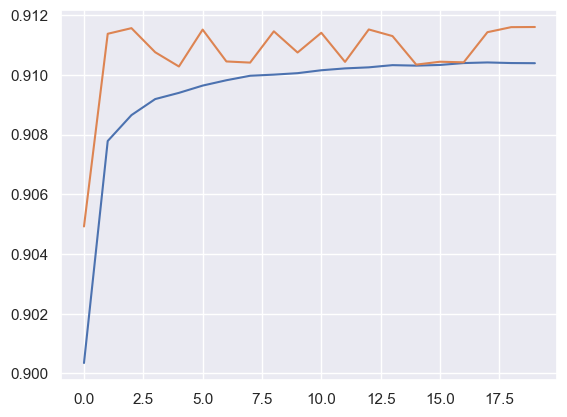

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])